In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
%cd ../utils
from outlier_cleaner import outlierCleaner

/Users/hoangnguyen/Documents/Github/music-analysis/utils


In [4]:
data = pd.read_csv('../data/dfLongterm.csv')
y = pd.read_csv('../data/dfY.csv')

In [5]:
df = pd.concat([data,y['valence_mean'], y['arousal_mean']], axis=1)

In [6]:
df.head()

,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,...,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33,valence_mean,arousal_mean
0,137.14,-210.30,70.38,-1.80,13.52,7.67,9.21,-4.23,3.85,-2.07,...,0.41,0.43,0.20,0.17,0.26,0.54,0.42,0.45,3.1,3.0
1,96.00,-321.79,105.26,16.30,33.23,11.20,28.95,12.95,16.30,2.92,...,0.41,0.38,0.27,0.22,0.09,0.05,0.12,0.25,3.5,3.3
2,174.55,-216.06,88.31,-8.95,41.89,18.97,7.79,-2.24,5.94,0.00,...,0.44,0.21,0.09,0.18,0.31,0.67,0.40,0.53,5.7,5.5
3,49.23,-185.45,85.01,-8.47,3.75,-17.62,6.10,-14.41,-8.74,-7.15,...,0.53,0.20,0.26,0.09,0.14,0.17,0.31,0.33,4.4,5.3
4,120.00,-209.14,69.00,30.20,31.84,14.17,22.39,5.16,12.23,0.63,...,0.12,0.22,0.23,0.18,0.17,0.17,0.43,0.82,5.8,6.4


In [7]:
df.shape

(1802, 35)

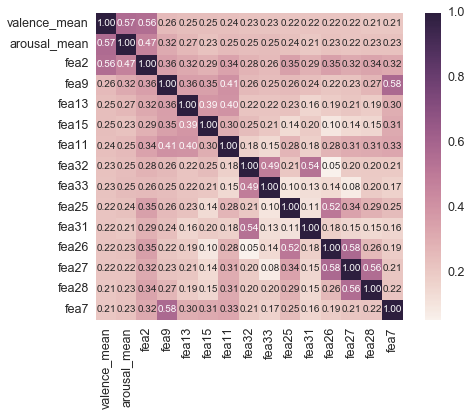

In [8]:
k = 15 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'valence_mean')['valence_mean'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#plt.savefig('heatmap.png')

# Data preprocessing

## Remove outliers

In [9]:
df.shape

(1802, 35)

In [10]:
def Cleaner(df, x, y):
    """
    x, y: dataframe
    """
    #convert to numpy array
    x = np.reshape(np.array(df[x]), (len(df), 1))
    y = np.reshape(np.array(df[y]), (len(df), 1))
    
    #fit
    reg = LinearRegression()
    reg.fit(x, y)
    predictions = reg.predict(x)
    cleaned_list = outlierCleaner(predictions, x, y)[1] #return a list of outlier values
    cleaned_list =  np.reshape(np.array(cleaned_list), (len(cleaned_list), 1))
    return cleaned_list

### valence_mean

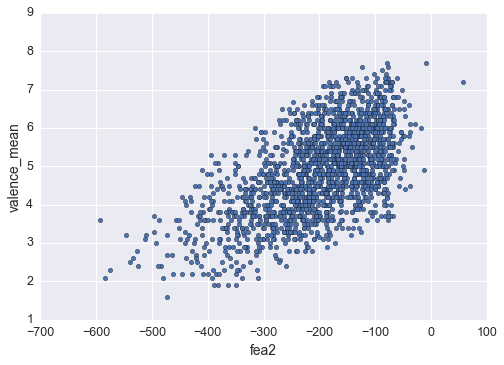

In [18]:
# scatter plot
x = 'fea2'
y = 'valence_mean'
temp = pd.concat([df[y], df[x]], axis=1)
temp.plot.scatter(x, y);

In [12]:
# fea2
cleaned_list = Cleaner(df, 'fea2', 'valence_mean')
for i in cleaned_list:
    df = df[df.fea2 != i[0]]

In [13]:
cleaned_list.shape, df.shape

((40, 1), (1760, 35))

### arousal_mean

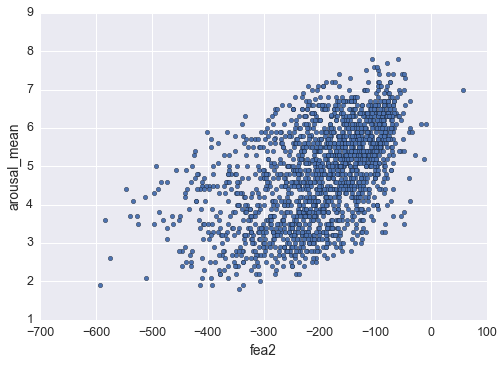

In [17]:
# scatter plot
x = 'fea2'
y = 'arousal_mean'
temp = pd.concat([df[y], df[x]], axis=1)
temp.plot.scatter(x, y);

In [15]:
# fea2
cleaned_list = Cleaner(df, 'fea2', 'arousal_mean')
for i in cleaned_list:
    df = df[df.fea2 != i[0]]

In [16]:
cleaned_list.shape, df.shape

((40, 1), (1720, 35))

## Scale data

In [21]:
x = df.drop(['valence_mean', 'arousal_mean'], 1)
y = pd.concat([df['valence_mean'], df['arousal_mean']],1)

In [22]:
x.shape, y.shape

((1720, 33), (1720, 2))

In [23]:
scaler = StandardScaler()

In [24]:
scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
data_scaled = scaler.transform(x)

In [26]:
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

In [28]:
data_scaled.head()

,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,...,fea24,fea25,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33
0,0.645389,-0.082167,-0.778614,-0.049898,-0.771804,0.609500,0.200215,-0.243520,0.160489,0.295217,...,-0.107051,0.109812,0.327089,0.594910,-0.715599,-0.997184,-0.437066,0.918737,0.368388,0.429294
1,-0.702851,-1.249980,0.138619,0.662457,0.553031,0.910044,1.933442,1.834294,1.527843,0.974880,...,1.078787,1.597032,0.327089,0.306184,-0.294226,-0.717259,-1.477173,-1.824908,-1.371073,-0.707733
2,1.871390,-0.142500,-0.307112,-0.331298,1.135125,1.571579,0.075535,-0.002842,0.390029,0.577161,...,-0.538265,-0.663542,0.494478,-0.675484,-1.377757,-0.941199,-0.131152,1.646643,0.252424,0.884105
3,-2.235597,0.178127,-0.393892,-0.312406,-1.428509,-1.543683,-0.072852,-1.474728,-1.222240,-0.396705,...,-0.592167,1.061633,0.996644,-0.733229,-0.354422,-1.445064,-1.171259,-1.152995,-0.269414,-0.252922
4,0.083677,-0.070016,-0.814904,1.209514,0.459600,1.162909,1.357456,0.892142,1.080845,0.662970,...,-1.724103,-1.555875,-1.291002,-0.617739,-0.535011,-0.941199,-0.987711,-1.152995,0.426370,2.532794


In [29]:
def modelTest(clf, train, labels):
    cv = KFold(n_splits=5,shuffle=True,random_state=45).split(train)
    mse = make_scorer(mean_squared_error)
    mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
    scores=[mse_val_score.mean()]
    return scores

In [30]:
def modelPlot(result_dict):
    result = pd.DataFrame.from_dict(result_dict, orient='index')
    result.columns = ["Mean Squared Error"] 
    result = result.sort(columns=["Mean Squared Error"],ascending=False)
    #print(result)
    result.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return result

In [31]:
def modelFit(train, labels):
    result_dict = {}
    '''
    clf = linear_model.LinearRegression()
    result_dict["Linear"] = modelTest(clf, train, labels)
    
    clf = linear_model.Lasso(alpha=1e-4)
    result_dict["Lasso"] = modelTest(clf, train, labels)
    
    clf = linear_model.Ridge()
    result_dict["Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.BayesianRidge()
    result_dict["Bayesian Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.HuberRegressor()
    result_dict["Huber"] = modelTest(clf, train, labels)
    
    clf = svm.SVR()
    result_dict["SVM RBF"] = modelTest(clf, train, labels)
    
    clf = svm.SVR(kernel="linear")
    result_dict["SVM Linear"] = modelTest(clf, train, labels)
    
    clf = BaggingRegressor()
    result_dict["Bagging"] = modelTest(clf, train, labels)
    
    clf = RandomForestRegressor()
    result_dict["RandomForest"] = modelTest(clf, train, labels)
    '''
    clf = AdaBoostRegressor()
    result_dict["AdaBoost"] = modelTest(clf, train, labels)
    
    clf = XGBRegressor()
    result_dict["XGBoost"] = modelTest(clf, train, labels)
    
    model_summary = modelPlot(result_dict)
    return model_summary

,Mean Squared Error
AdaBoost,0.777092
XGBoost,0.751941


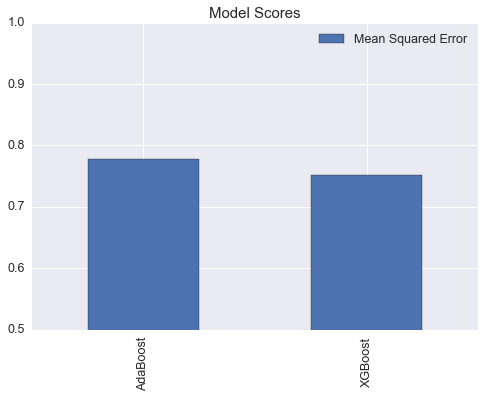

In [32]:
modelFit(data_scaled, y['valence_mean'])
#modelFit(data, y['valence_mean'])

# Run best model 

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
def create_model(model, data, y):
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    sns.regplot(x=y_pred, y=y_test)
    print(np.corrcoef(y_pred, y_test))
    print(mean_squared_error(y_test, y_pred))

In [35]:
clf_valence = XGBRegressor()

[[ 1.          0.63370687]
 [ 0.63370687  1.        ]]
0.752259316292


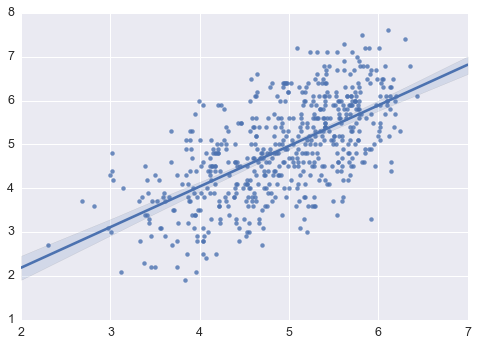

In [37]:
create_model(clf_valence, data_scaled.as_matrix(), np.array(y['valence_mean']))

[[ 1.          0.61838614]
 [ 0.61838614  1.        ]]
0.962337085329


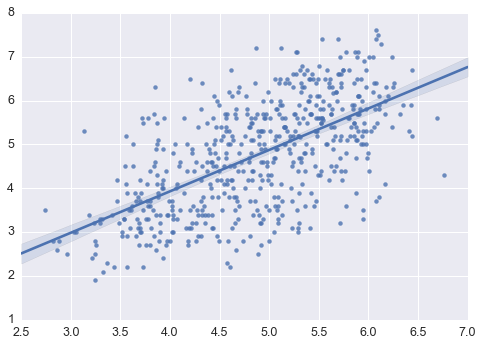

In [38]:
clf_arousal = XGBRegressor()
create_model(clf_arousal, data_scaled.as_matrix(), np.array(y['arousal_mean']))

## Reference about correlation metric to evaluate model
http://imgur.com/a/gX89A

https://classroom.udacity.com/courses/ud501/lessons/4802891095/concepts/49196894850923

## Check important features

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20

In [ ]:
plot_importance(clf_valence, height=0.5)
plt.savefig('feas_importance.png')
plt.show()

In [ ]:
clf_valence.booster().get_fscore()

# Remove feature and re-run model

In [ ]:
data_removed = data.copy()

In [ ]:
del data_removed['fea13']
del data_removed['fea22']

In [ ]:
clf_valence_removed = XGBRegressor()
create_model(clf_valence_removed, data_removed.as_matrix(), np.array(y['valence_mean']))

In [ ]:
clf_valence_removed.booster().get_fscore()

# Experiment with different model and show error rate

In [ ]:
clf_arousal_ridge = linear_model.Ridge()
create_model(clf_arousal_ridge, data_scaled, np.array(y['arousal_mean']))

In [ ]:
df_compare_arousal = pd.DataFrame({"arousal_target": y_test['arousal_mean'], "arousal_pred": y_pred_arousal})

In [ ]:
df_compare_arousal['ErrorRate']= df_compare_arousal.apply(lambda row: abs(row['arousal_pred']-row['arousal_target'])/row['arousal_target'], axis=1)
df_compare_arousal.describe()

In [ ]:
df_compare = pd.DataFrame({"valence_target": y_test['valence_mean'], "valence_pred": y_pred})

In [ ]:
df_compare.head()

In [ ]:
df_compare['ErrorRate']= df_compare.apply(lambda row: abs(row['valence_pred']-row['valence_target'])/row['valence_target'], axis=1)

In [ ]:
df_compare['ErrorRate'].describe()

In [ ]:
clfRandom = RandomForestRegressor()
clfRandom.fit(X_train, y_train['valence_mean'])
y_pred_valence_RandomF = clfRandom.predict(X_test)
mean_squared_error(y_test['valence_mean'], y_pred_valence_RandomF)

In [ ]:
import pickle

In [ ]:
def save_model(model, fileName):
    f = open('./'+fileName, 'wb')
    pickle.dump(model, f)

In [ ]:
save_model(clf_valence, "valence_model.sav")
save_model(clf_arousal, "arousal_model.sav")

# Fine Tune

In [ ]:
feature = [ 0.65519038, -0.07628927, -0.77544214, -0.03422748, -0.76500356,
        0.62507754,  0.2090739 , -0.23296932,  0.16704597,  0.30380077,
       -0.12093146,  0.84937125,  0.6236305 , -0.73196571,  1.23342518,
        0.64840883, -0.29515861,  0.66941854,  0.67054655,  0.07763418,
        0.35497932,  0.65683281, -0.80359708, -0.09453569,  0.11972583,
        0.34251675,  0.6077862 , -0.7165535 , -0.99956607, -0.43536672,
        0.91738949,  0.36843219,  0.42423349]

In [ ]:
feature2= data.loc[2,:]

In [ ]:
np.array(feature2)

In [ ]:
y.loc[2,:]

In [ ]:
model = pickle.load(open('./valence_model.sav', 'rb'))

In [ ]:
model.predict(feature2)

In [ ]:
# Create k-fold
#kf = KFold(n_splits=5, shuffle=True, random_state=7).split(X_train)
#scorer = make_scorer(mean_squared_error, greater_is_better=True)

In [ ]:
def paraSearch(model, data, y, parameters):
    scorer = make_scorer(mean_squared_error, greater_is_better=True)
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=7)
    gs = GridSearchCV(model, parameters, cv=5, scoring=scorer)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_, gs.best_estimator_

In [ ]:
#XGBRegressor
xgb_params = {
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.6, 0.7],
    'learning_rate': [0.075, 0.05, 0.03, 0.01, 0.1, 0.5],
    'max_depth': [1, 3, 5, 7, 9, 11, 13],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 150, 200],
    'reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],
    'reg_lambda': [0.1, 0.5, 0.7, 1],
}

In [ ]:
paraSearch(clf_valence, data, y['valence_mean'], xgb_params)

In [ ]:
clf_valence

In [ ]:
clf_finetune =  XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
        gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=13,
        min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
        objective='reg:linear', reg_alpha=0, reg_lambda=0.5,
        scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [ ]:
create_model(clf_finetune, data.as_matrix(), y['arousal_mean'])

In [ ]:
y_pred_finetune = clf_finetune.predict(data.as_matrix())

In [ ]:
dfPredValenceFinetune=pd.DataFrame(y_pred_finetune, columns=['valence_mean_predicted'])

In [ ]:
import pickle

In [ ]:
pickle.dump(dfPredValenceFinetune, open('./dfPredValenceFinetune', 'wb'))

In [ ]:
dfPredValenceFinetune.to_csv('./y_pred_arousal_finetune.csv')

In [ ]:
plt.plot(y['valence_mean'], y_pred_finetune)

In [ ]:
mean_squared_error(y_test['valence_mean'], y_pred_finetune)

In [ ]:
from hpsklearn import HyperoptEstimator

In [ ]:
from hyperopt import hp

In [ ]:
from hpsklearn import any_regressor

In [ ]:
def run_experiments(
        experimental_run,
        dataset,
        model_class=XGBR,
        loss=LOG_LOSS,
        test_metric=accuracy_score,
        random_state=None,
        dataset_name=None):
    """
    Basic experimental framework.
    Parameters
    ----------
    experimental_run : list of tuples
        These tuples should have exactly three members: the first one
        of `grid_search`, `randomized_search`, `hyperopt_search`,
        `skopt_gp_minimize`, `skopt_forest_minimize`, or
        `skopt_forest_gbrt`, the second an appropriate `param_grid`
        dict for that function, and the third a dict specifying
        keyword arguments to the search function.
    dataset : (np.array, iterable)
        A dataset (X, y) where `X` has dimension
        `(n_samples, n_features)` and `y` has
         dimension `n_samples`.
    
    model_class : classifier
        A classifier model in the mode of `sklearn`, with at least
        `fit` and `predict` methods operating on things like
        `X` and `y`.
    loss : function or string
        An appropriate loss function or string recognizable by
        `sklearn.cross_validation.cross_val_score`. In `sklearn`, scores
        are positive and losses are negative because they maximize,
        but here we are minimizing so we always want smaller to mean
        better.
    test_metric : function
        An `sklearn.metrics` function.
    random_state : int
    dataset_name : str or None
        Informal name to give the dataset. Purely for
        book-keeping.
    Returns
    -------
    list of dict
       Each dict is a results dictionary of the sort returned
       by `assess`.
    """                    
    X, y = dataset    
    skf = get_cross_validation_indices(
        X, y, random_state=random_state)        
    all_results = []
    # This loop can easily be parallelized, but doing so can
    # be tricky on some systems, since `cross_val_score`
    # calls `joblib` even if `n_jobs=1`, resulting in
    # nested parallel jobs even if there is no actual
    # parallelization elsewhere in the experimental run.
    for search_func, param_grid, kwargs in experimental_run:
        print(search_func.__name__)
        all_results.append(
            assess(
                X, y,                
                search_func=search_func, 
                model_class=XGBClassifier, 
                param_grid=param_grid,
                xval_indices=skf,
                loss=loss,
                test_metric=test_metric,                
                dataset_name=dataset_name,
                search_func_args=kwargs))
    return all_results


In [ ]:
a = np.array([1,2,3])

In [ ]:
a.var

In [ ]:
a.itemset()